Preparation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import ResNet34_Weights
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import zipfile
import shutil

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
zip_path = 'TestDataSet.zip'
extract_dir = './TestDataSet'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
shutil.rmtree('./TestDataSet/__MACOSX', ignore_errors=True)
inner_dir = './TestDataSet/TestDataSet'
if os.path.isdir(inner_dir):
    for subdir in os.listdir(inner_dir):
        shutil.move(os.path.join(inner_dir, subdir), './TestDataSet')
    os.rmdir(inner_dir)

Model

In [4]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]


Task 1

In [5]:
def evaluate(model, dataloader, folder_idx_to_id=None, topk=(1, 5)):
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)

            if folder_idx_to_id is not None:
                if isinstance(targets, torch.Tensor):
                    targets = targets.tolist()
                labels = torch.tensor(
                    [folder_idx_to_id[idx] for idx in targets],
                    device=device
                )
            else:
                labels = targets.to(device)

            outputs = model(images)

            _, preds_top1 = torch.max(outputs, 1)
            correct_top1 += (preds_top1 == labels).sum().item()

            _, preds_top5 = torch.topk(outputs, k=5, dim=1)
            for i in range(len(labels)):
                if labels[i] in preds_top5[i]:
                    correct_top5 += 1

            total += len(labels)

    return 100 * correct_top1 / total, 100 * correct_top5 / total

In [6]:
with open('./TestDataSet/labels_list.json', 'r') as f:
    labels_list = json.load(f)

folder_idx_to_id = {
    idx: int(labels_list[idx].split(":")[0])
    for idx in range(len(labels_list))
}

top1, top5 = evaluate(pretrained_model, dataloader, folder_idx_to_id)
print(f"Top-1 Accuracy: {top1:.2f}%")
print(f"Top-5 Accuracy: {top5:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


Task 2

In [7]:
def fgsm(images, labels, model, epsilon):
    images = images.clone().detach().to(device)
    images.requires_grad_(True)

    loss = torch.nn.functional.cross_entropy(model(images), labels)
    loss.backward()

    eps_tensor = torch.tensor([epsilon/0.229, epsilon/0.224, epsilon/0.225], device=device).view(1,3,1,1)
    adv = images + eps_tensor * images.grad.sign()

    min_norm = torch.tensor((0 - mean_norms)/std_norms, device=device).view(1,3,1,1)
    max_norm = torch.tensor((1 - mean_norms)/std_norms, device=device).view(1,3,1,1)
    adv = torch.clamp(adv, min=min_norm, max=max_norm)
    return adv.detach()

In [8]:
adv_root = './AdvTestSet1'
os.makedirs(adv_root, exist_ok=True)
for cls in dataset.classes:
    os.makedirs(os.path.join(adv_root, cls), exist_ok=True)

unnorm = transforms.Normalize(mean=(-mean_norms/std_norms).tolist(), std=(1.0/std_norms).tolist())

viz_samples = []
saved_idx = {c:0 for c in dataset.classes}

pretrained_model.eval()
loader = DataLoader(dataset, batch_size=32, shuffle=False)
max_diff = 0 # set max diff to 0 and replace it with real max diff

for imgs, tgt_idx in loader:
    imgs = imgs.to(device)
    labels = torch.tensor([folder_idx_to_id[int(t)] for t in tgt_idx],device=device)
    adv_imgs = fgsm(imgs, labels, pretrained_model, epsilon=0.02)

    # Make sure L∞ distance between new and original is no greater than ε = 0.02
    imgs_ori = unnorm(imgs.cpu())
    adv_ori = unnorm(adv_imgs.cpu())
    for i in range(imgs_ori.size(0)):
        max_diff = (adv_ori[i] - imgs_ori[i]).abs().max().item()

    for k in range(imgs.size(0)):
        cls_name = dataset.classes[tgt_idx[k].item()]
        fname = f"{saved_idx[cls_name]:05d}.png"
        save_path = os.path.join(adv_root, cls_name, fname)
        save_image(unnorm(adv_imgs[k].cpu()), save_path)
        saved_idx[cls_name] += 1

    if len(viz_samples) < 3:
        with torch.no_grad():
            pred_clean = pretrained_model(imgs).argmax(1)
            pred_adv = pretrained_model(adv_imgs.float()).argmax(1)
        for i in range(imgs.size(0)):
            if (pred_clean[i] == labels[i]) and (pred_adv[i] != labels[i]):
                viz_samples.append((unnorm(imgs[i].cpu()), unnorm(adv_imgs[i].cpu())))
            if len(viz_samples) == 3:
                break
print(f"Max L∞ distance = {max_diff:.3f}")

Max L∞ distance = 0.020


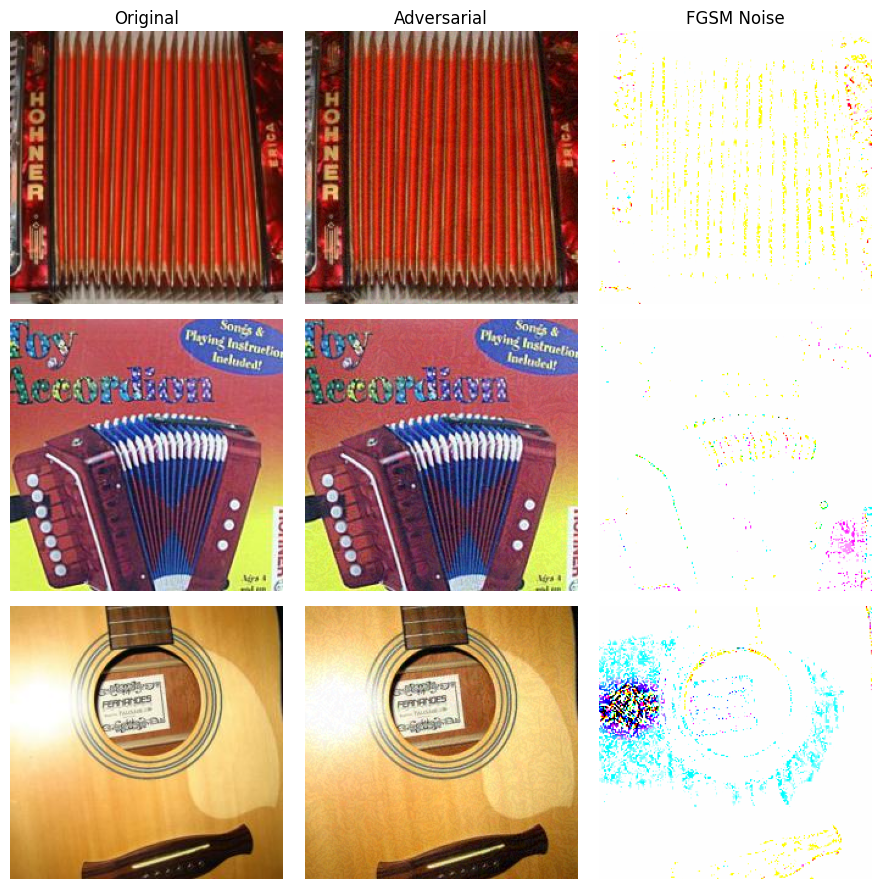

In [9]:
plt.figure(figsize=(9, len(viz_samples)*3))
for idx, (ori, adv) in enumerate(viz_samples):
    diff = (adv - ori).abs(); vmax = diff.max()
    for j, pic in enumerate([ori, adv, diff]):
        ax = plt.subplot(len(viz_samples), 3, idx*3 + j + 1)
        ax.imshow((pic/vmax if j==2 else pic).permute(1,2,0))
        ax.axis('off')
        if idx == 0:
            ax.set_title(['Original', 'Adversarial', 'FGSM Noise'][j])
plt.tight_layout(); plt.show()

In [10]:
adv_dataset   = torchvision.datasets.ImageFolder(root=adv_root, transform=plain_transforms)
adv_dataloader = DataLoader(adv_dataset, batch_size=32, shuffle=False)
top1_adv, top5_adv = evaluate(pretrained_model, adv_dataloader, folder_idx_to_id)
print(f'FGSM Top-1 Accuracy: {top1_adv:.2f}%')
print(f'FGSM Top-5 Accuracy: {top5_adv:.2f}%')

FGSM Top-1 Accuracy: 3.80%
FGSM Top-5 Accuracy: 21.00%


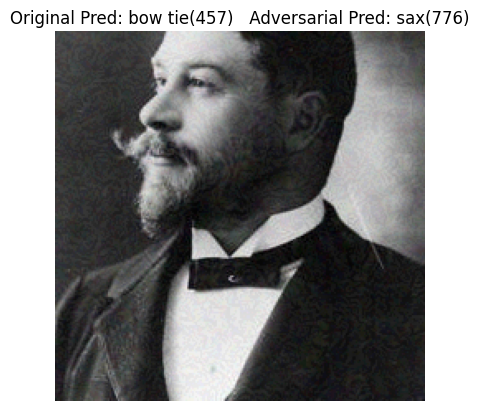

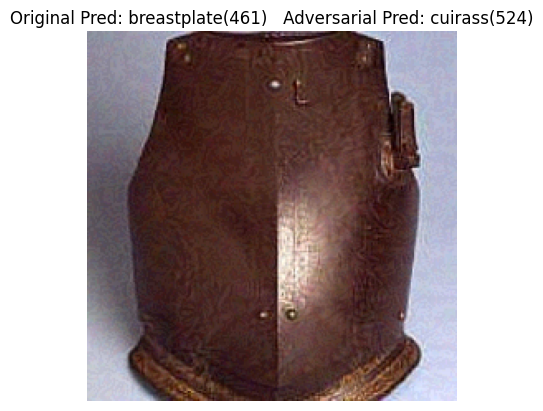

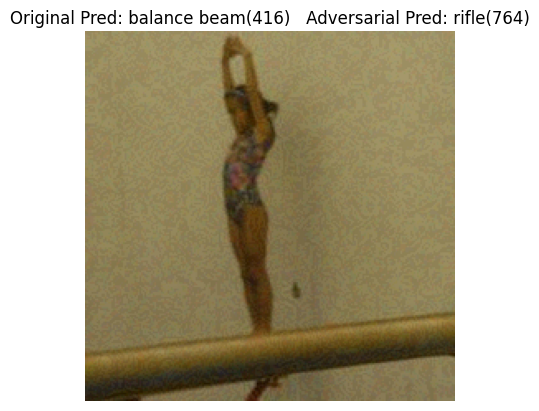

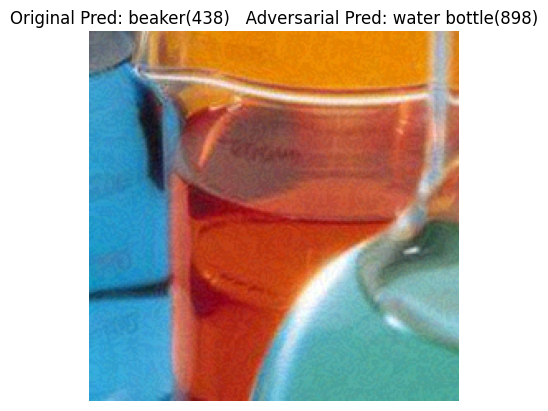

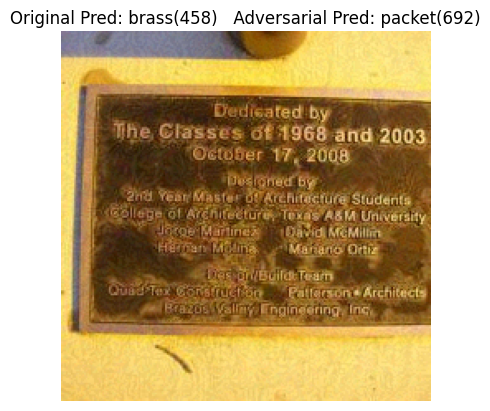

In [11]:
def visualize_failures(model, dataset, adv_dataset, k):
    imagenet_labels = ResNet34_Weights.IMAGENET1K_V1.meta["categories"]
    idxs = torch.randperm(len(dataset))
    model.eval()
    n = 0
    with torch.no_grad():
        for i in idxs:
            xc, t = dataset[i]; xa, _ = adv_dataset[i]
            gt = folder_idx_to_id[t]
            pc = model(xc.unsqueeze(0).to(device)).argmax().item()
            pa = model(xa.unsqueeze(0).to(device)).argmax().item()
            # Select only formerly correct predicted but get wrong after the attack
            if pc == gt and pa != gt:
                plt.imshow(unnorm(xa).permute(1,2,0).cpu())
                plt.title(f'Original Pred: {imagenet_labels[gt]}({gt})   Adversarial Pred: {imagenet_labels[pa]}({pa})')
                plt.axis('off'); plt.show()
                n += 1
                if n == k: break

visualize_failures(pretrained_model, dataset, adv_dataset, k=5)

Task 3

In [12]:
def pgd(x, y, model, epsilon=0.02, alpha=0.004, steps=10):
    x = x.clone().detach().to(device).float()
    y = y.to(device)
    eps_t   = torch.tensor([epsilon/0.229,  epsilon/0.224,  epsilon/0.225], device=device, dtype=torch.float32).view(1,3,1,1)
    alpha_t = torch.tensor([alpha/0.229, alpha/0.224, alpha/0.225], device=device, dtype=torch.float32).view(1,3,1,1)
    min_n = torch.tensor((0-mean_norms)/std_norms, device=device, dtype=torch.float32).view(1,3,1,1)
    max_n = torch.tensor((1-mean_norms)/std_norms, device=device, dtype=torch.float32).view(1,3,1,1)

    x_adv = x + torch.empty_like(x).uniform_(-1, 1) * eps_t
    for _ in range(steps):
        x_adv.requires_grad_(True)
        torch.nn.functional.cross_entropy(model(x_adv), y).backward()
        x_adv = x_adv + alpha_t * x_adv.grad.sign()
        x_adv = torch.max(torch.min(x_adv, x + eps_t), x - eps_t)
        x_adv = torch.clamp(x_adv, min=min_n, max=max_n).detach()
    return x_adv

adv_root = './AdvTestSet2'
os.makedirs(adv_root, exist_ok=True)
for c in dataset.classes: os.makedirs(os.path.join(adv_root, c), exist_ok=True)
unnorm = transforms.Normalize((-mean_norms/std_norms).tolist(), (1./std_norms).tolist())

viz, saved = [], {c:0 for c in dataset.classes}
loader = DataLoader(dataset, batch_size=32, shuffle=False)
max_diff = 0
pretrained_model.eval()

for imgs, idx in loader:
    imgs = imgs.to(device)
    labels = torch.tensor([folder_idx_to_id[int(t)] for t in idx], device=device)
    adv = pgd(imgs, labels, pretrained_model)

    imgs_ori = unnorm(imgs.cpu())
    adv_ori = unnorm(adv.cpu())
    for i in range(imgs_ori.size(0)):
        max_diff = (adv_ori[i] - imgs_ori[i]).abs().max().item()

    for i in range(imgs.size(0)):
        cls = dataset.classes[idx[i]]
        name = f'{saved[cls]:05d}.png'
        save_image(unnorm(adv[i].cpu()), os.path.join(adv_root, cls, name))
        saved[cls] += 1

    if len(viz) < 3:
        with torch.no_grad():
            clean_ok = pretrained_model(imgs).argmax(1)
            adv_bad  = pretrained_model(adv).argmax(1)
        for i in range(imgs.size(0)):
            if clean_ok[i] == labels[i] and adv_bad[i] != labels[i]:
                viz.append((unnorm(imgs[i].cpu()), unnorm(adv[i].cpu())))
                if len(viz) == 3:
                    break
print(f"Max L∞ distance = {max_diff:.3f}")

Max L∞ distance = 0.020


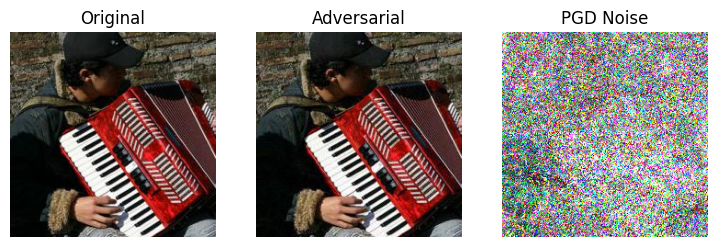

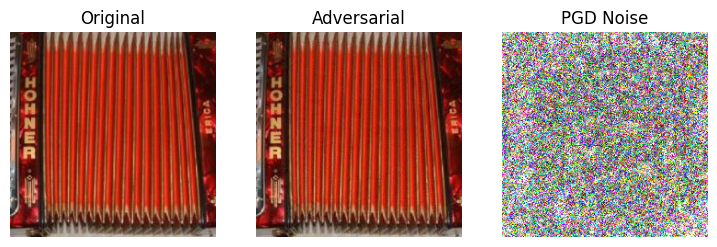

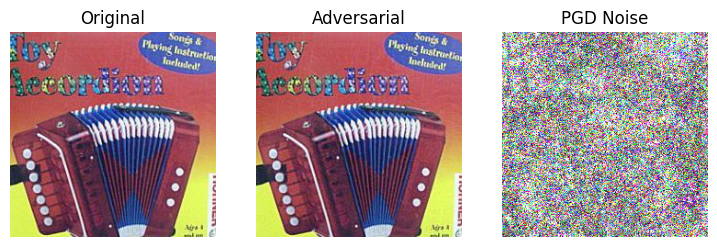

In [13]:
for ori, adv in viz:
    diff = (adv - ori).abs()
    vmax = diff.max()
    plt.figure(figsize=(9,3))
    for j, img in enumerate([ori, adv, diff/vmax]):
        plt.subplot(1,3,j+1)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        plt.title(['Original', 'Adversarial', 'PGD Noise'][j])
    plt.show()

In [14]:
pgd_dataset = torchvision.datasets.ImageFolder(adv_root, transform=plain_transforms)
pgd_dataloader = DataLoader(pgd_dataset, batch_size=32, shuffle=False)
top1_pgd, top5_pgd = evaluate(pretrained_model, pgd_dataloader, folder_idx_to_id)
print(f'PGD Top-1 Accuracy: {top1_pgd:.2f}%')
print(f'PGD Top-5 Accuracy: {top5_pgd:.2f}%')

PGD Top-1 Accuracy: 0.00%
PGD Top-5 Accuracy: 1.60%


Task 4

In [15]:
def patch_pgd_adv(x, y, model, patch=32, epsilon=0.5, steps=40, restarts=3, mu=1.0):
    x = x.clone().detach().to(device).float(); y = y.to(device)
    B,_,H,W = x.shape
    eps_t = torch.tensor([epsilon/0.229, epsilon/0.224, epsilon/0.225], device=device, dtype=torch.float32).view(1,3,1,1)
    alpha_t = eps_t / steps
    min_n = torch.tensor((0-mean_norms)/std_norms, device=device, dtype=torch.float32).view(1,3,1,1)
    max_n = torch.tensor((1-mean_norms)/std_norms, device=device, dtype=torch.float32).view(1,3,1,1)

    best_adv = x.clone()
    best_loss = torch.full((B,), -1e9, device=device)

    for _ in range(restarts):
        xs = torch.randint(0, W-patch+1, (B,), device=device)
        ys = torch.randint(0, H-patch+1, (B,), device=device)
        mask = torch.zeros((B,1,H,W), device=device)
        for i in range(B):
            mask[i,:, ys[i]:ys[i]+patch, xs[i]:xs[i]+patch] = 1.

        adv = x + (torch.empty_like(x).uniform_(-1,1)*eps_t)*mask
        mom = torch.zeros_like(adv)

        for _ in range(steps):
            adv.requires_grad_(True)
            loss = torch.nn.functional.cross_entropy(model(adv), y)
            loss.backward()
            grad = adv.grad / adv.grad.abs().mean([1,2,3], keepdim=True)
            mom = mu * mom + grad
            adv  = adv + alpha_t * mom.sign() * mask
            delta = torch.clamp(adv - x, -eps_t, eps_t) * mask
            adv   = torch.clamp(x + delta, min=min_n, max=max_n).detach()

        with torch.no_grad():
            final_loss = torch.nn.functional.cross_entropy(model(adv), y, reduction='none')
            better = final_loss > best_loss
            best_loss[better] = final_loss[better]
            best_adv[better]  = adv[better]

    return best_adv.float()

adv_root = './AdvTestSet3'
os.makedirs(adv_root, exist_ok=True)
for c in dataset.classes: os.makedirs(os.path.join(adv_root, c), exist_ok=True)
unnorm = transforms.Normalize((-mean_norms/std_norms).tolist(), (1./std_norms).tolist())
viz, saved = [], {c:0 for c in dataset.classes}
loader = DataLoader(dataset, batch_size=32, shuffle=False)
max_diff = 0
pretrained_model.eval()

for imgs, idx in loader:
    imgs = imgs.to(device)
    labels = torch.tensor([folder_idx_to_id[int(t)] for t in idx], device=device)
    adv = patch_pgd_adv(imgs, labels, pretrained_model)

    imgs_ori = unnorm(imgs.cpu())
    adv_ori = unnorm(adv.cpu())
    for i in range(imgs_ori.size(0)):
        max_diff = (adv_ori[i] - imgs_ori[i]).abs().max().item()

    for i in range(imgs.size(0)):
        cls = dataset.classes[idx[i]]
        name = f'{saved[cls]:05d}.png'
        save_image(unnorm(adv[i].cpu()), os.path.join(adv_root, cls, name))
        saved[cls] += 1

    if len(viz) < 3:
        with torch.no_grad():
            pc = pretrained_model(imgs).argmax(1)
            pa = pretrained_model(adv).argmax(1)
        for i in range(imgs.size(0)):
            if pc[i]==labels[i] and pa[i]!=labels[i]:
                viz.append((unnorm(imgs[i].cpu()), unnorm(adv[i].cpu())))
                if len(viz)==3: break
print(f"Max L∞ distance = {max_diff:.3f}")

Max L∞ distance = 0.500


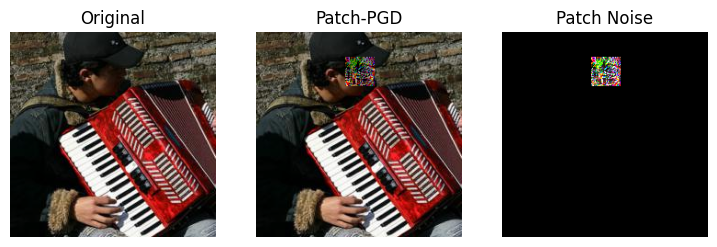

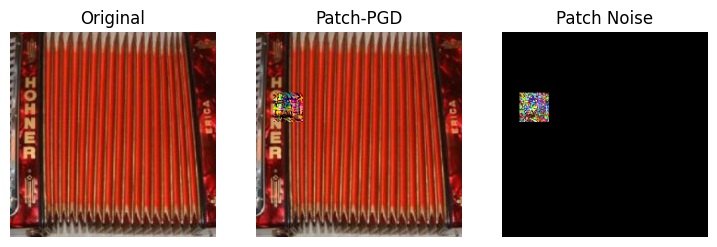

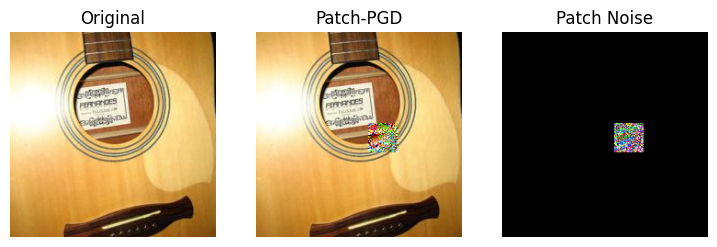

In [16]:
for ori, adv in viz:
    diff, vmax = (adv-ori).abs(), (adv-ori).abs().max()
    plt.figure(figsize=(9,3))
    for j, im in enumerate([ori, adv, diff/vmax]):
        plt.subplot(1,3,j+1); plt.imshow(im.permute(1,2,0)); plt.axis('off')
        plt.title(['Original','Patch-PGD','Patch Noise'][j])
    plt.show()

In [17]:
patch_dataset = torchvision.datasets.ImageFolder(adv_root, transform=plain_transforms)
patch_dataloader = DataLoader(patch_dataset, batch_size=32, shuffle=False)
top1_patch, top5_patch = evaluate(pretrained_model, patch_dataloader, folder_idx_to_id)
print(f'Patch-PGD Top-1 Accuracy: {top1_patch:.2f}%')
print(f'Patch-PGD Top-5 Accuracy: {top5_patch:.2f}%')

Patch-PGD Top-1 Accuracy: 10.00%
Patch-PGD Top-5 Accuracy: 50.60%


Task 5

In [18]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device).eval()

sets = {
    'Original': './TestDataSet',
    'FGSM': './AdvTestSet1',
    'PGD': './AdvTestSet2',
    'Patch': './AdvTestSet3',
}

def make_loader(path):
    ds = torchvision.datasets.ImageFolder(path, transform=plain_transforms)
    return DataLoader(ds, batch_size=32, shuffle=False, num_workers=4)

loaders = {name: make_loader(p) for name, p in sets.items()}

top1_dense = []
top5_dense = []
print('DenseNet-121 Accuracy:')
for name, loader in loaders.items():
    top1_new, top5_new = evaluate(new_model, loader, folder_idx_to_id)
    top1_dense.append(top1_new)
    top5_dense.append(top5_new)
    print(f'{name:<8}:  Top-1: {top1_new:6.2f}%, Top-5: {top5_new:6.2f}%')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 129MB/s]


DenseNet-121 Accuracy:
Original:  Top-1:  74.60%, Top-5:  93.60%
FGSM    :  Top-1:  46.40%, Top-5:  75.80%
PGD     :  Top-1:  44.80%, Top-5:  80.80%
Patch   :  Top-1:  67.00%, Top-5:  88.60%


In [19]:
originals = [
    ('Original', top1, top5),
    ('FGSM', top1_adv, top5_adv),
    ('PGD', top1_pgd, top5_pgd),
    ('Patch', top1_patch, top5_patch)
]

print('Overall Accuracy:\n\nResNet-34:')
for original in originals:
    print(f'{original[0]:<8}: Top-1: {original[1]:6.2f}%, Top-5: {original[2]:6.2f}%')
print('\nDenseNet-121:')
for i in range(len(top1_dense)):
    print(f'{originals[i][0]:<8}: Top-1: {top1_dense[i]:6.2f}%, Top-5: {top5_dense[i]:6.2f}%')

Overall Accuracy:

ResNet-34:
Original: Top-1:  76.00%, Top-5:  94.20%
FGSM    : Top-1:   3.80%, Top-5:  21.00%
PGD     : Top-1:   0.00%, Top-5:   1.60%
Patch   : Top-1:  10.00%, Top-5:  50.60%

DenseNet-121:
Original: Top-1:  74.60%, Top-5:  93.60%
FGSM    : Top-1:  46.40%, Top-5:  75.80%
PGD     : Top-1:  44.80%, Top-5:  80.80%
Patch   : Top-1:  67.00%, Top-5:  88.60%
